<a href="https://colab.research.google.com/github/AhadChowdhury12/Data-Migration---SQLite-to-Neo4J/blob/main/Lung_Disease_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# setting up kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Downloading the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# Unzip the dataset
# !unzip lung-disease.zip


cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:07<00:00, 308MB/s]
100% 2.29G/2.29G [00:07<00:00, 345MB/s]


In [3]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [4]:
train_dir = '/content/chest_xray/chest_xray/train'  # Update this to your training directory path
val_dir = '/content/chest_xray/chest_xray/val'      # Update this to your validation directory path
test_dir = '/content/chest_xray/chest_xray/test'    # Update this to your testing directory path


**X-ray images**

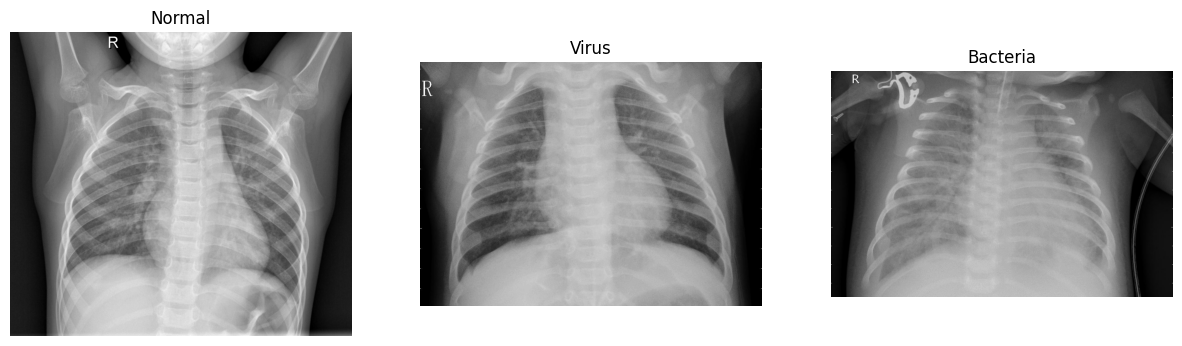

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Paths to the images
image_paths = [
    "/content/chest_xray/train/NORMAL/IM-0115-0001.jpeg",
    "/content/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg",
    "/content/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg"
]

# Titles for the images
titles = ["Normal", "Virus", "Bacteria"]

# Create a figure to display the images
plt.figure(figsize=(15, 10))

# Loop through the images
for i, (path, title) in enumerate(zip(image_paths, titles)):
    # Read the image
    img = mpimg.imread(path)

    # Add a subplot for each image
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

# Show the figure
plt.show()


**Counting Images in Each Class:**

In [6]:
import os

def count_images_in_directory(directory):
    image_count = {}

    # Traverse each class folder inside the directory
    for class_label in os.listdir(directory):
        class_dir = os.path.join(directory, class_label)

        if os.path.isdir(class_dir):  # Check if it's a directory (class folder)
            count = len([img for img in os.listdir(class_dir) if img.endswith(('.png', '.jpg', '.jpeg'))])
            image_count[class_label] = count

    return image_count

# Directory paths
train_dir = '/content/chest_xray/chest_xray/train'
val_dir = '/content/chest_xray/chest_xray/val'
test_dir = '/content/chest_xray/chest_xray/test'

# Count images in each dataset
train_image_count = count_images_in_directory(train_dir)
val_image_count = count_images_in_directory(val_dir)
test_image_count = count_images_in_directory(test_dir)

# Print the number of images in each class for each dataset
print(f"Training Data: {train_image_count}")
print(f"Validation Data: {val_image_count}")
print(f"Test Data: {test_image_count}")


Training Data: {'PNEUMONIA': 3875, 'NORMAL': 1341}
Validation Data: {'PNEUMONIA': 8, 'NORMAL': 8}
Test Data: {'PNEUMONIA': 390, 'NORMAL': 234}


**Augmenting 'Normal' Class in Training Data:**

In [8]:
# Augment 'Normal' Class in Training Data

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Set up the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Directory paths for 'Normal' class in training data
train_normal_dir = os.path.join(train_dir, 'NORMAL')

# Augment 'Normal' images
normal_generator = datagen.flow_from_directory(
    train_dir,
    classes=['NORMAL'],
    target_size=(224, 224),
    batch_size=32,
    save_to_dir=train_normal_dir,  # Save augmented images in the same folder
    save_prefix='aug_',            # Prefix to identify augmented images
    save_format='jpeg',
    class_mode=None
)

# Generate enough augmented images to balance the dataset
num_augmented_images = 3873 - 1341  # Number of images needed to balance
for i in range((num_augmented_images // 32) + 1):  # Create batches of 32 images
    next(normal_generator)  # Use next() to advance the generator


Found 1341 images belonging to 1 classes.


**Moving Data from Training to Validation:**

In [9]:
# Move 300 Images from Training to Validation

import shutil
import random
import os

# Paths for 'Normal' and 'Pneumonia' classes in the training and validation directories
train_normal_dir = os.path.join(train_dir, 'NORMAL')
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

val_normal_dir = os.path.join(val_dir, 'NORMAL')
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA')

# Function to move files from training to validation
def move_images(src_dir, dest_dir, num_images):
    # List all files in the source directory
    images = os.listdir(src_dir)
    # Randomly shuffle the files
    random.shuffle(images)
    # Move the specified number of images
    for img in images[:num_images]:
        shutil.move(os.path.join(src_dir, img), os.path.join(dest_dir, img))

# Move 300 'Normal' images from training to validation
move_images(train_normal_dir, val_normal_dir, 300)

# Move 300 'Pneumonia' images from training to validation
move_images(train_pneumonia_dir, val_pneumonia_dir, 300)


**Creating Data Generators (without Augmentation):**

In [10]:
# Create new data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Validation data generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 7173 images belonging to 2 classes.
Found 616 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**CNN Model**

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Adjust based on your data
    validation_data=val_generator
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('cnn_model.h5')


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.6806 - loss: 0.5710 - val_accuracy: 0.9237 - val_loss: 0.1911
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.9209 - loss: 0.2236 - val_accuracy: 0.9513 - val_loss: 0.1475
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.9470 - loss: 0.1595 - val_accuracy: 0.9416 - val_loss: 0.1366
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 192ms/step - accuracy: 0.9575 - loss: 0.1387 - val_accuracy: 0.9123 - val_loss: 0.2093
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.9470 - loss: 0.1442 - val_accuracy: 0.9448 - val_loss: 0.1575
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 197ms/step - accuracy: 0.9593 - loss: 0.1145 - val_accuracy: 0.9481 - val_loss: 0.1103
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.9606 - loss: 0.1152 - val_accuracy: 0.9594 - val_loss: 0.1125
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 207ms/step - accuracy: 0.9685 - loss: 0

Test Loss: 0.9876988530158997, Test Accuracy: 0.7804487347602844


** visualization of the training epochs**

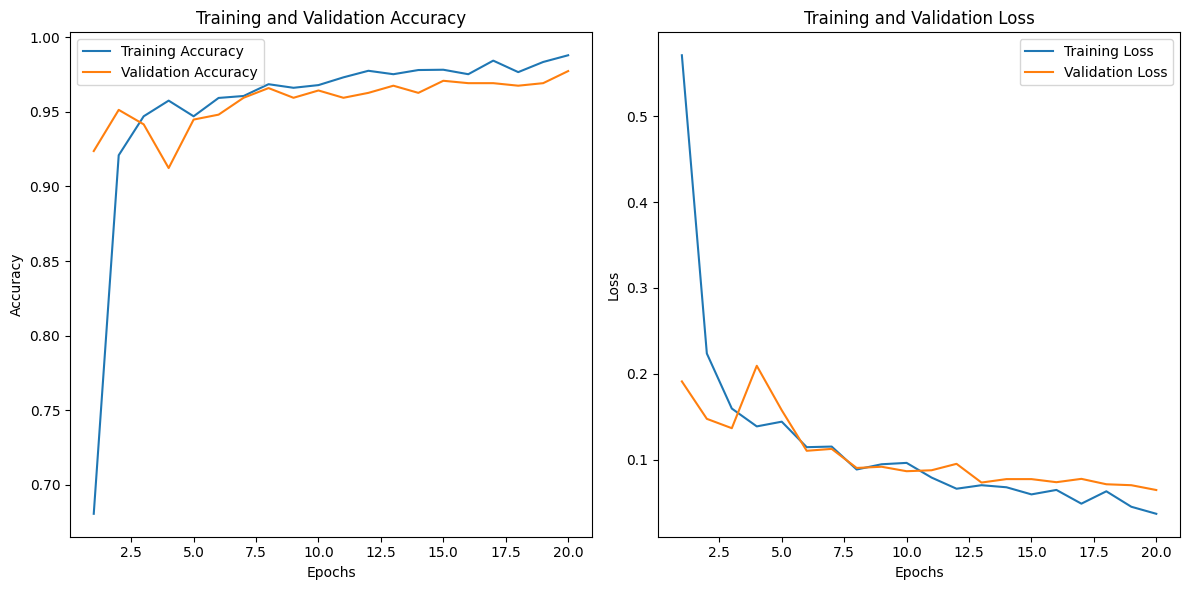

In [13]:
import matplotlib.pyplot as plt

# Data from the training and validation process
epochs = list(range(1, 21))
train_accuracy = [0.6806, 0.9209, 0.9470, 0.9575, 0.9470, 0.9593, 0.9606, 0.9685, 0.9661, 0.9679, 0.9731, 0.9775, 0.9752, 0.9780, 0.9782, 0.9752, 0.9843, 0.9766, 0.9834, 0.9879]
train_loss = [0.5710, 0.2236, 0.1595, 0.1387, 0.1442, 0.1145, 0.1152, 0.0885, 0.0946, 0.0962, 0.0791, 0.0661, 0.0702, 0.0678, 0.0595, 0.0647, 0.0487, 0.0631, 0.0451, 0.0369]
val_accuracy = [0.9237, 0.9513, 0.9416, 0.9123, 0.9448, 0.9481, 0.9594, 0.9659, 0.9594, 0.9643, 0.9594, 0.9627, 0.9675, 0.9627, 0.9708, 0.9692, 0.9692, 0.9675, 0.9692, 0.9773]
val_loss = [0.1911, 0.1475, 0.1366, 0.2093, 0.1575, 0.1103, 0.1125, 0.0903, 0.0917, 0.0865, 0.0876, 0.0951, 0.0733, 0.0773, 0.0773, 0.0737, 0.0776, 0.0713, 0.0702, 0.0646]

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Test Accuracy**

In [15]:
# Get the accuracy and loss from the test set evaluation
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.6334 - loss: 1.5760
Test Accuracy: 0.7804487347602844
Test Loss: 0.9876988530158997


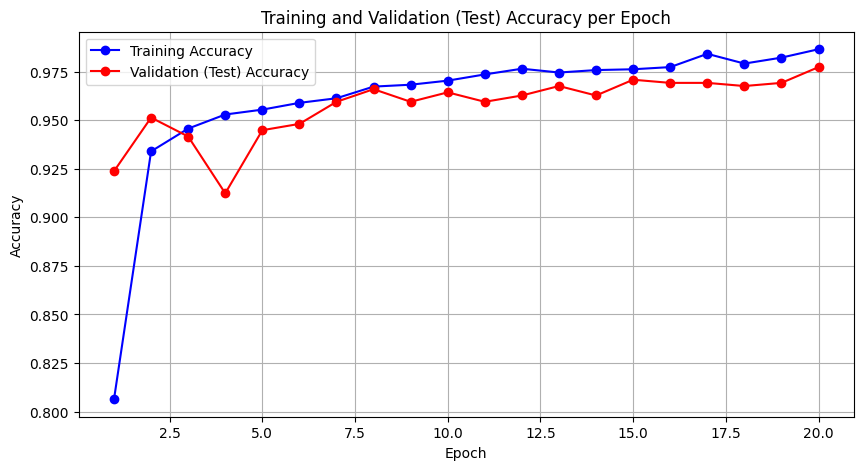

In [18]:
import matplotlib.pyplot as plt

# Extract accuracy from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Define epochs range based on the number of epochs
epochs = range(1, len(training_accuracy) + 1)

# Create a line plot for training and validation (test) accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'ro-', label='Validation (Test) Accuracy')
plt.title('Training and Validation (Test) Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**Grad CAM**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the model
model = tf.keras.models.load_model('cnn_model.h5')

# Function to make Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # Get the last convolutional layer
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # Create a model that maps the image input to the activations of the last conv layer
    grad_model = Model([model.inputs], [last_conv_layer.output, model.output])

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Get the gradients of the predicted class with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the pooled gradients by the feature map
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Load and preprocess the input image (use the appropriate path)
img_path = '/content/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Define the last convolutional layer and classifier layers
last_conv_layer_name = 'conv2d_2'  # Adjust based on the layer names in your model
classifier_layer_names = ["flatten", "dense_2", "dropout", "dense_3"]

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
plt.matshow(heatmap)
plt.show()

# Overlay the heatmap on the original image
def overlay_heatmap(heatmap, img, alpha=0.4, colormap='viridis'):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap(colormap)
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

# Apply the heatmap to the original image
original_img = image.img_to_array(image.load_img(img_path))
superimposed_img = overlay_heatmap(heatmap, original_img)

# Display the image with heatmap
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


**Fine-Tuning with VGG16 Model:**

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('cnn_vgg16_model.h5')


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 53s 209ms/step - accuracy: 0.8844 - loss: 0.2460 - val_accuracy: 0.9675 - val_loss: 0.0784 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.9750 - loss: 0.0711 - val_accuracy: 0.9789 - val_loss: 0.0591 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.9808 - loss: 0.0505 - val_accuracy: 0.9838 - val_loss: 0.0474 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.9869 - loss: 0.0434 - val_accuracy: 0.9805 - val_loss: 0.0539 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.9890 - loss: 0.0373 - val_accuracy: 0.9740 - val_loss: 0.0777 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.9884 - loss: 0.0339 - val_accuracy: 0.9805 - val_loss: 0.0467 - learning_rate: 1.0000

Test Loss: 0.6938359141349792, Test Accuracy: 0.8141025900840759


Modified Version VGG16

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Directory paths
train_dir = '/content/chest_xray/chest_xray/train'
val_dir = '/content/chest_xray/chest_xray/val'
test_dir = '/content/chest_xray/chest_xray/test'

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training, Validation, and Test Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Load VGG16 base model with pre-trained ImageNet weights, excluding top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Learning rate reduction and early stopping callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('cnn_vgg16_modell.h5')


Found 7173 images belonging to 2 classes.
Found 616 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 118s 497ms/step - accuracy: 0.8200 - loss: 0.3909 - val_accuracy: 0.9269 - val_loss: 0.2125 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 111s 477ms/step - accuracy: 0.9147 - loss: 0.2235 - val_accuracy: 0.9367 - val_loss: 0.1831 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 115s 496ms/step - accuracy: 0.9160 - loss: 0.2166 - val_accuracy: 0.9269 - val_loss: 0.1803 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 111s 476ms/step - accuracy: 0.9235 - loss: 0.1960 - val_accuracy: 0.9383 - val_loss: 0.1562 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 111s 482ms/step - accuracy: 0.9366 - loss: 0.1776 - val_accuracy: 0.9334 - val_loss: 0.1943 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 113s 486ms/step - accuracy: 0.9310 -

Test Loss: 0.3660353720188141, Test Accuracy: 0.8717948794364929


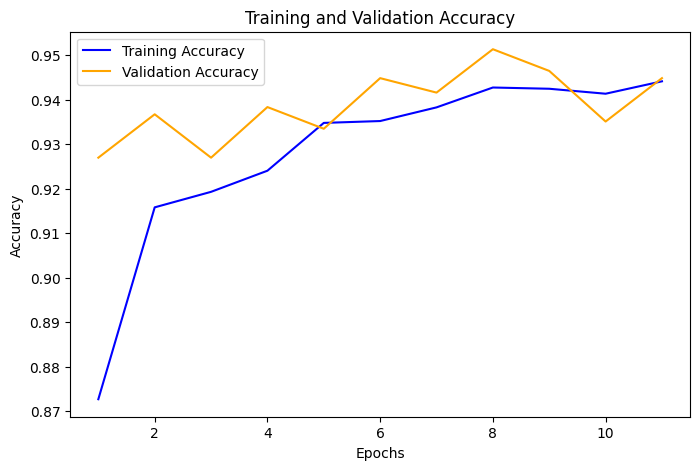

Final Test Accuracy: 87.1%


In [38]:
import matplotlib.pyplot as plt

# Extract accuracy and validation accuracy from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Print the test accuracy
print(f"Final Test Accuracy: 87.1%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step


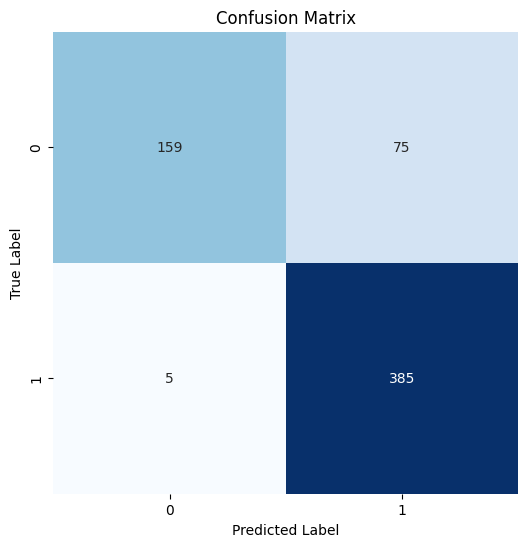

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'test_generator' is already created and is used with shuffle=False

# Predict the labels for the test set
test_generator.reset()  # Resetting generator to ensure predictions and labels correspond
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)  # Convert probabilities to class labels

# Get true class labels
true_classes = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [40]:
from sklearn.metrics import classification_report

# Assuming predictions and true_classes are already defined from the previous snippet

# Calculate precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes, target_names=['Normal', 'Pneumonia'])
print(report)


              precision    recall  f1-score   support

      Normal       0.97      0.68      0.80       234
   Pneumonia       0.84      0.99      0.91       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.89      0.87      0.87       624



In [41]:
import numpy as np
from sklearn.metrics import roc_auc_score

# Predict probabilities for the test set
test_probabilities = model.predict(test_generator, steps=len(test_generator))
test_labels = test_generator.classes  # True labels

# Calculate the AUC-ROC
auc = roc_auc_score(test_labels, test_probabilities)
print(f"AUC-ROC: {auc:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step
AUC-ROC: 0.96


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step


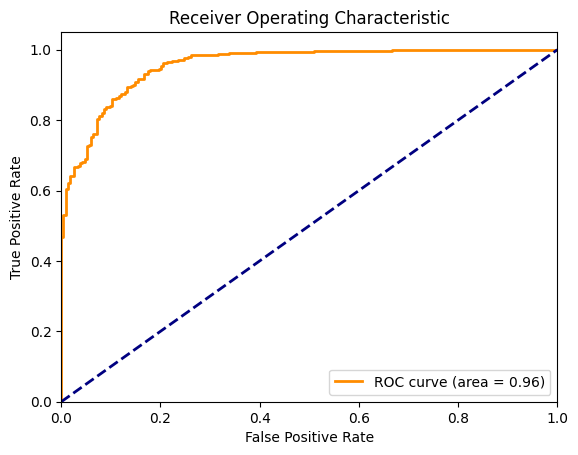

In [43]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'test_generator' is already created and properly configured
# Make sure that shuffle=False in your test_generator to maintain label order

# Step 1: Predict probabilities
predictions = model.predict(test_generator)
y_scores = predictions.ravel()  # Flatten predictions array if necessary

# Step 2: Extract true labels from the generator
y_test = test_generator.classes

# Step 3: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Step 4: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


** ResNet50 Model:**

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('cnn_resnet50_model.h5')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 64s 234ms/step - accuracy: 0.6375 - loss: 0.7911 - val_accuracy: 0.8279 - val_loss: 0.4749 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.8114 - loss: 0.4697 - val_accuracy: 0.8701 - val_loss: 0.3949 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 47s 203ms/step - accuracy: 0.8605 - loss: 0.3849 - val_accuracy: 0.8718 - val_loss: 0.3400 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 196ms/step - accuracy: 0.8786 - loss: 0.3352 - val_accuracy: 0.8864 - val_loss: 0.2915 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.8874 - loss: 0.3005 - val_accuracy: 0.8880 - val_loss: 0.2713 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.8978 - loss: 0.2680 - val_accuracy: 0.8831 - val_loss: 0.2818 - learning_rate: 1.0000

Test Loss: 0.41565996408462524, Test Accuracy: 0.8285256624221802


Modifying version of ResNet50

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Directory paths
train_dir = '/content/chest_xray/chest_xray/train'
val_dir = '/content/chest_xray/chest_xray/val'
test_dir = '/content/chest_xray/chest_xray/test'

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data preprocessing
datagen = ImageDataGenerator(rescale=1./255)

# Training, Validation, and Test Generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Load ResNet50 base model with pre-trained ImageNet weights, excluding top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Learning rate reduction and early stopping callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('cnn_resnet50_model.h5')


Found 7173 images belonging to 2 classes.
Found 616 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 60s 220ms/step - accuracy: 0.6511 - loss: 0.7871 - val_accuracy: 0.7922 - val_loss: 0.4891 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 209ms/step - accuracy: 0.8064 - loss: 0.4571 - val_accuracy: 0.8701 - val_loss: 0.3914 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.8384 - loss: 0.3990 - val_accuracy: 0.8555 - val_loss: 0.3564 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.8695 - loss: 0.3509 - val_accuracy: 0.8799 - val_loss: 0.3021 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.8782 - loss: 0.3185 - val_accuracy: 0.8815 - val_loss: 0.2911 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.8901 - loss:

Test Loss: 0.38164934515953064, Test Accuracy: 0.8445512652397156


**InceptionV3 Model**

In [21]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('cnn_inceptionv3_model.h5')


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 72s 254ms/step - accuracy: 0.8684 - loss: 0.4220 - val_accuracy: 0.9545 - val_loss: 0.1054 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.9511 - loss: 0.1358 - val_accuracy: 0.9659 - val_loss: 0.0873 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 192ms/step - accuracy: 0.9730 - loss: 0.0744 - val_accuracy: 0.9692 - val_loss: 0.0780 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.9747 - loss: 0.0685 - val_accuracy: 0.9627 - val_loss: 0.0835 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 192ms/step - accuracy: 0.9793 - loss: 0.0546 - val_accuracy: 0.9627 - val_loss: 0.0933 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 207ms/step - accuracy: 0.9850 - loss: 0.0430 - val_accuracy: 0.9724 - val_loss: 0.0675 - learning_rate: 1.0000

Test Loss: 0.7943436503410339, Test Accuracy: 0.8092948794364929


**EfficientNetB0 Model**

In [22]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('cnn_efficientnetb0_model.h5')


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 83s 278ms/step - accuracy: 0.4972 - loss: 0.8389 - val_accuracy: 0.5000 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 198ms/step - accuracy: 0.5022 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.4903 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.4971 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 192ms/step - accuracy: 0.5105 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-05
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.5114 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000

Test Loss: 0.6931749582290649, Test Accuracy: 0.375


**LungNet22 Model Implementation:**

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the LungNet22 model
model = Sequential([
    base_model,

    # Add an additional block to learn complex patterns
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Global Average Pooling to reduce the dimensions
    GlobalAveragePooling2D(),

    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout for regularization

    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the model
model.save('lungnet22_model.h5')


Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 57s 218ms/step - accuracy: 0.8233 - loss: 0.3904 - val_accuracy: 0.9367 - val_loss: 0.1595 - learning_rate: 1.0000e-04
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - accuracy: 0.9515 - loss: 0.1329 - val_accuracy: 0.9627 - val_loss: 0.1075 - learning_rate: 1.0000e-04
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.9605 - loss: 0.1087 - val_accuracy: 0.9708 - val_loss: 0.0910 - learning_rate: 1.0000e-04
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 49s 210ms/step - accuracy: 0.9692 - loss: 0.0806 - val_accuracy: 0.9692 - val_loss: 0.0835 - learning_rate: 1.0000e-04
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 196ms/step - accuracy: 0.9747 - loss: 0.0679 - val_accuracy: 0.9724 - val_loss: 0.0731 - learning_rate: 1.0000e-04
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - accuracy: 0.9796 - loss: 0.0578 - val_accuracy: 0.9740 - val_loss: 0.0666 - learning_rate: 1.0000e-04
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 45s 19

Test Loss: 0.6880236268043518, Test Accuracy: 0.8060897588729858
